# Lição 4 - Processamento de Linguagem Natural

## Autor
- Levi de Oliveira Queiroz
- Matrícula: 170108341
- GitHub: LeviQ27

## Objetivo

O objetivo do seguinte artigo é aplicar os conhecimentos adquiridos na lição 4 "[Lesson 4 - Natural Language(NLP)](https://course.fast.ai/Lessons/lesson4.html)", na qual ensina usando como exemplo a competição [Kaggle - U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) como treinar um modelo de liguagem natural e testar se a submissão feita é plágio ou não do treino dado para o modelo.  

## Metodologia

Seguindo os passos da [lição 4](https://course.fast.ai/Lessons/lesson4.html) foi montado a importação dos dados do us patent phrase to phrase matching, com eles foi aplicado os conceitos de tokenização utilizando o pré_modelo *microsoft/deberta-v3-small* e a função *AutoTokenizer* do pacote *Transformers*...

## Conclusão

Pela minha falta de organização de tempo não consegui finalizar o artigo de forma a aplicar o conceito de modelagem em liguagem natural, aplicando para verificar igualdade entre o treino feito no modelo e a variável para o modelo comparar, sendo aplicavel dentro de um aplicativo disponibilizado no [HuggingFace](https://huggingface.co/), preparei o ambiente para receber o app mas está vazio em [lesson4](https://huggingface.co/spaces/L27Queiroz/lesson4).

O notebook foi feito no Kaggle.

In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')

In [2]:
!pip install kaggle
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.4.0 requires cupy-cuda11x<12.0.0a0,>=9.5.0, which is not installed.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.2 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 whic

In [3]:
creds = ''

In [4]:
# for working with paths in Python, I recommend using 'pathlib.Path'

from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = Path('us-patent-phrase-to-phrase-matching')

In [6]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [7]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

In [8]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv(path/'train.csv')

In [11]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [12]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


In [13]:
df['input'] = 'text1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [14]:
df.input.head()

0    text1: A47; TEXT2: abatement of pollution; ANC...
1    text1: A47; TEXT2: act of abating; ANC1: abate...
2    text1: A47; TEXT2: active catalyst; ANC1: abat...
3    text1: A47; TEXT2: eliminating process; ANC1: ...
4    text1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [15]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [16]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [17]:
model_nm = 'microsoft/deberta-v3-small'

In [18]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer

tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
tokz.tokenize("G'day folks, I'm Jeremy From fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁From',
 '▁fast',
 '.',
 'ai',
 '!']

In [29]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [30]:
def tok_func(x): return tokz(x["input"])

In [31]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [32]:
row = tok_ds[0]
row['input'], row['input_ids']

('text1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  1529,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [37]:
tokz.vocab['of']

1580

In [38]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [39]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [40]:
def f(x): return -3*x**2 + 2*x + 20

In [44]:
import numpy as np, matplotlib.pyplot as plt

def plt_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

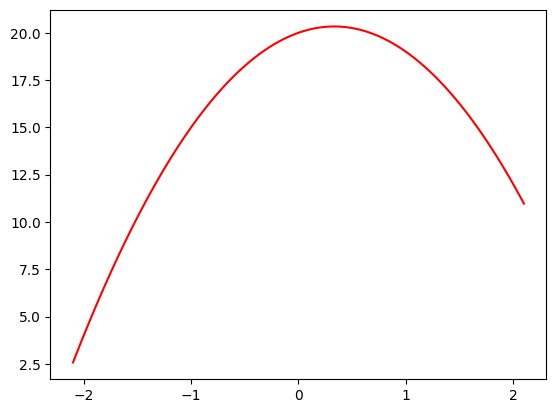

In [45]:
plt_function(f)

In [47]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [48]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

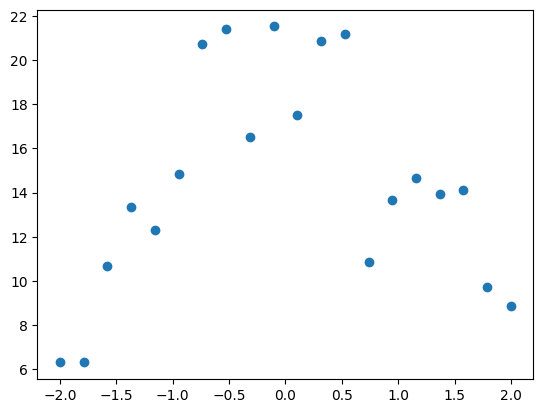

In [49]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plt_function(model.predict)

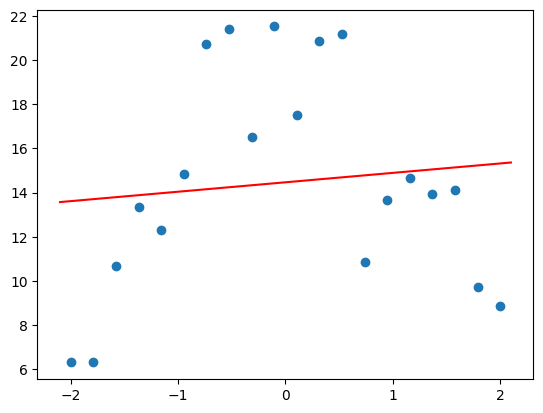

In [51]:
plot_poly(1)

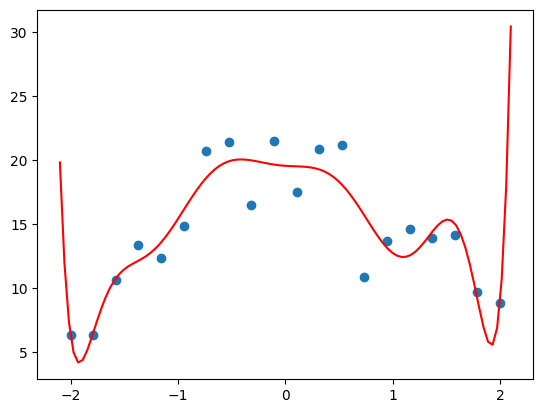

In [52]:
plot_poly(10)

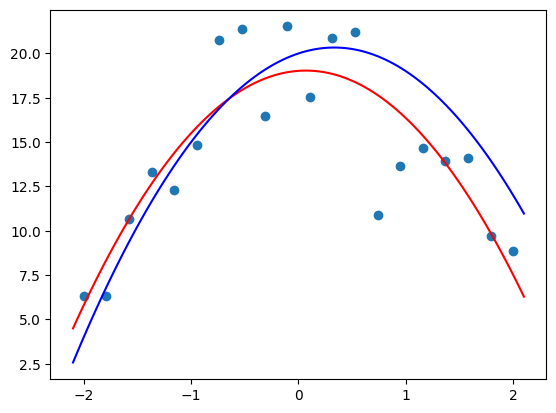

In [53]:
plot_poly(2)
plt_function(f, color='b')

In [54]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [56]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [58]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192


In [60]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [61]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [62]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906006

In [64]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

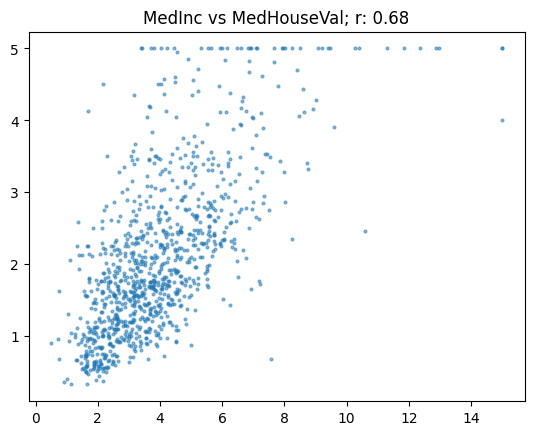

In [65]:
show_corr(housing, 'MedInc', 'MedHouseVal')

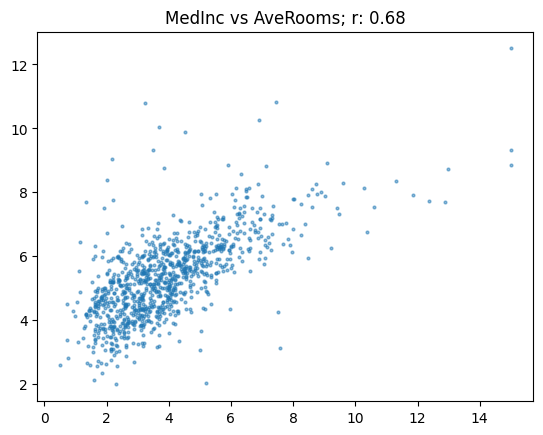

In [67]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

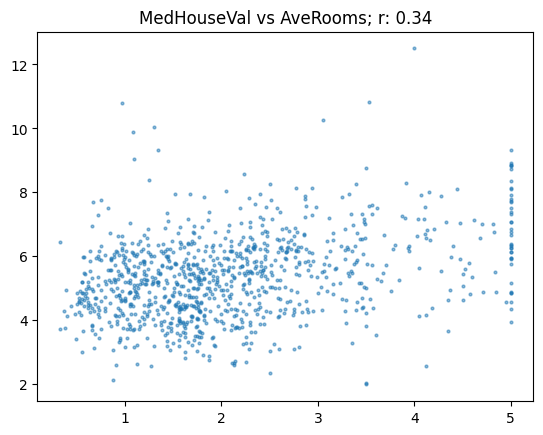

In [68]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

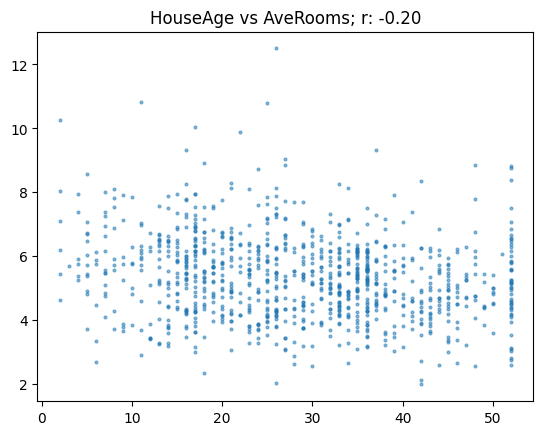

In [69]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [70]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [71]:
from transformers import TrainingArguments,Trainer

In [72]:
bs = 128
epochs = 4

In [73]:
lr = 8e-5

In [75]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True, evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [76]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [77]:
trainer.train();

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.030101,0.781705
2,No log,0.023840,0.820017
3,No log,0.022895,0.827077
4,No log,0.023417,0.828403


In [78]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.55],
       [ 0.75],
       [ 0.51],
       [ 0.37],
       [ 0.  ],
       [ 0.55],
       [ 0.53],
       [ 0.03],
       [ 0.37],
       [ 1.13],
       [ 0.25],
       [ 0.26],
       [ 0.73],
       [ 0.71],
       [ 0.78],
       [ 0.44],
       [ 0.27],
       [-0.  ],
       [ 0.7 ],
       [ 0.33],
       [ 0.4 ],
       [ 0.25],
       [ 0.25],
       [ 0.24],
       [ 0.59],
       [-0.02],
       [-0.04],
       [-0.  ],
       [-0.05],
       [ 0.58],
       [ 0.34],
       [ 0.05],
       [ 0.73],
       [ 0.5 ],
       [ 0.45],
       [ 0.19]])

In [79]:
preds = np.clip(preds, 0, 1)

In [80]:
preds

array([[0.55],
       [0.75],
       [0.51],
       [0.37],
       [0.  ],
       [0.55],
       [0.53],
       [0.03],
       [0.37],
       [1.  ],
       [0.25],
       [0.26],
       [0.73],
       [0.71],
       [0.78],
       [0.44],
       [0.27],
       [0.  ],
       [0.7 ],
       [0.33],
       [0.4 ],
       [0.25],
       [0.25],
       [0.24],
       [0.59],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.58],
       [0.34],
       [0.05],
       [0.73],
       [0.5 ],
       [0.45],
       [0.19]])

In [82]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

856